In [16]:
import os
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pydub import AudioSegment
import pandas as pd
from IPython.display import Audio, display

In [17]:
# Set style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (14, 6)

In [18]:
def scan_audio_dataset(data_dir='data/raw'):
    """Scan the dataset and collect metadata"""
    dataset_info = []
    
    for class_name in os.listdir(data_dir):
        class_path = os.path.join(data_dir, class_name)
        if not os.path.isdir(class_path):
            continue
            
        for audio_file in os.listdir(class_path):
            if audio_file.endswith('.mp3'):
                file_path = os.path.join(class_path, audio_file)
                
                # Load audio to get metadata
                audio = AudioSegment.from_mp3(file_path)
                duration = len(audio) / 1000.0  # Convert to seconds
                
                dataset_info.append({
                    'class': class_name,
                    'filename': audio_file,
                    'path': file_path,
                    'duration_sec': duration,
                    'frame_rate': audio.frame_rate,
                    'channels': audio.channels
                })
    
    return pd.DataFrame(dataset_info)

# Scan dataset
print("Scanning dataset...")
df = scan_audio_dataset('../data/raw')

Scanning dataset...


In [19]:
# Display overview
print("\n" + "="*60)
print("DATASET OVERVIEW")
print("="*60)
print(f"\nTotal audio files: {len(df)}")
print(f"\nClass distribution:")
print(df['class'].value_counts())

print("\n" + "="*60)
print("AUDIO STATISTICS")
print("="*60)
print(f"\nDuration Statistics (seconds):")
print(df.groupby('class')['duration_sec'].describe())


DATASET OVERVIEW

Total audio files: 24

Class distribution:
class
car_honk        6
cat             6
dog             6
police_siren    6
Name: count, dtype: int64

AUDIO STATISTICS

Duration Statistics (seconds):
              count      mean       std    min     25%    50%      75%     max
class                                                                         
car_honk        6.0  1.920167  0.416005  1.071  2.0900  2.090  2.09000   2.090
cat             6.0  2.917167  2.558025  1.071  2.0900  2.090  2.09000   8.072
dog             6.0  4.236167  3.308099  1.071  2.3315  3.056  5.32925  10.057
police_siren    6.0  1.410667  0.526209  1.071  1.0710  1.071  1.83525   2.090


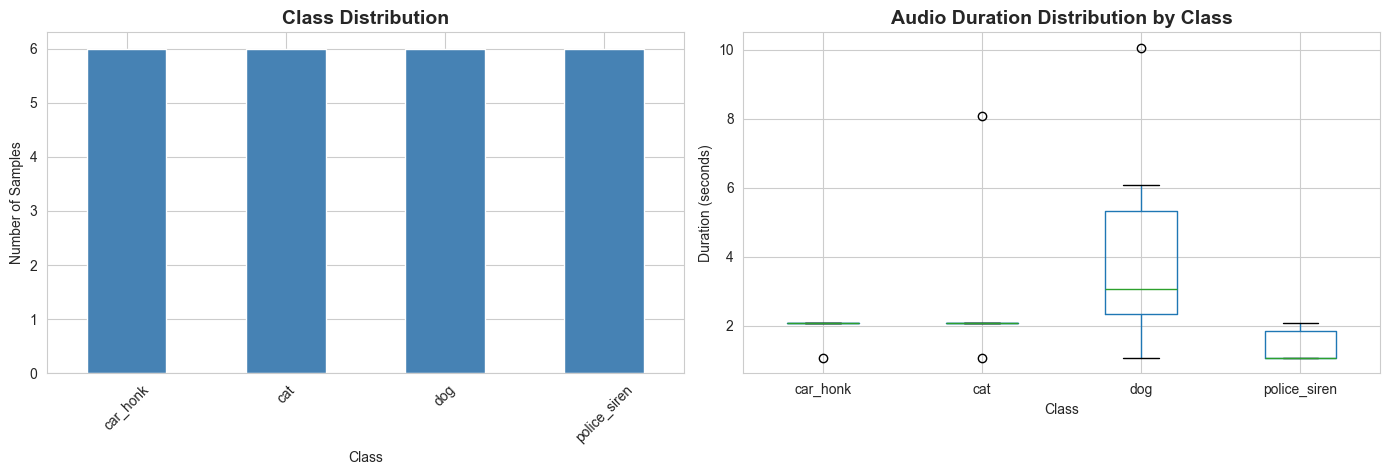

In [20]:
# Class distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Bar plot
df['class'].value_counts().plot(kind='bar', ax=axes[0], color='steelblue')
axes[0].set_title('Class Distribution', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Class')
axes[0].set_ylabel('Number of Samples')
axes[0].tick_params(axis='x', rotation=45)

# Duration boxplot
df.boxplot(column='duration_sec', by='class', ax=axes[1])
axes[1].set_title('Audio Duration Distribution by Class', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Class')
axes[1].set_ylabel('Duration (seconds)')
plt.suptitle('')

plt.tight_layout()
plt.show()


AUDIO SAMPLES VISUALIZATION

Analyzing: car_honk - Auto_Sound_Signal.mp3


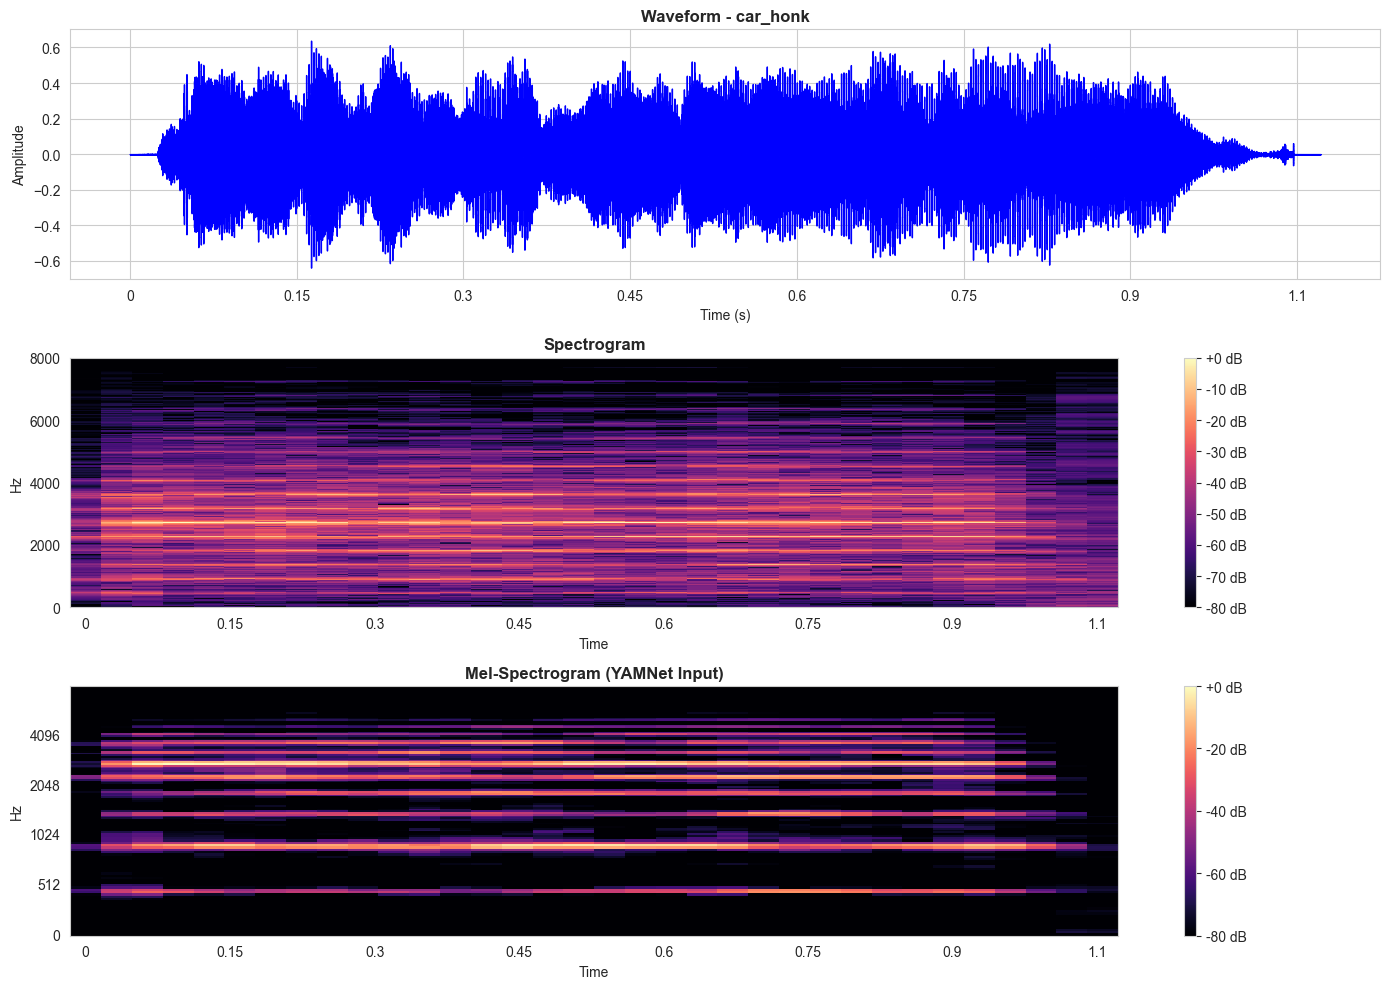

Playing audio from class: car_honk



Analyzing: cat - Cat_Call.mp3


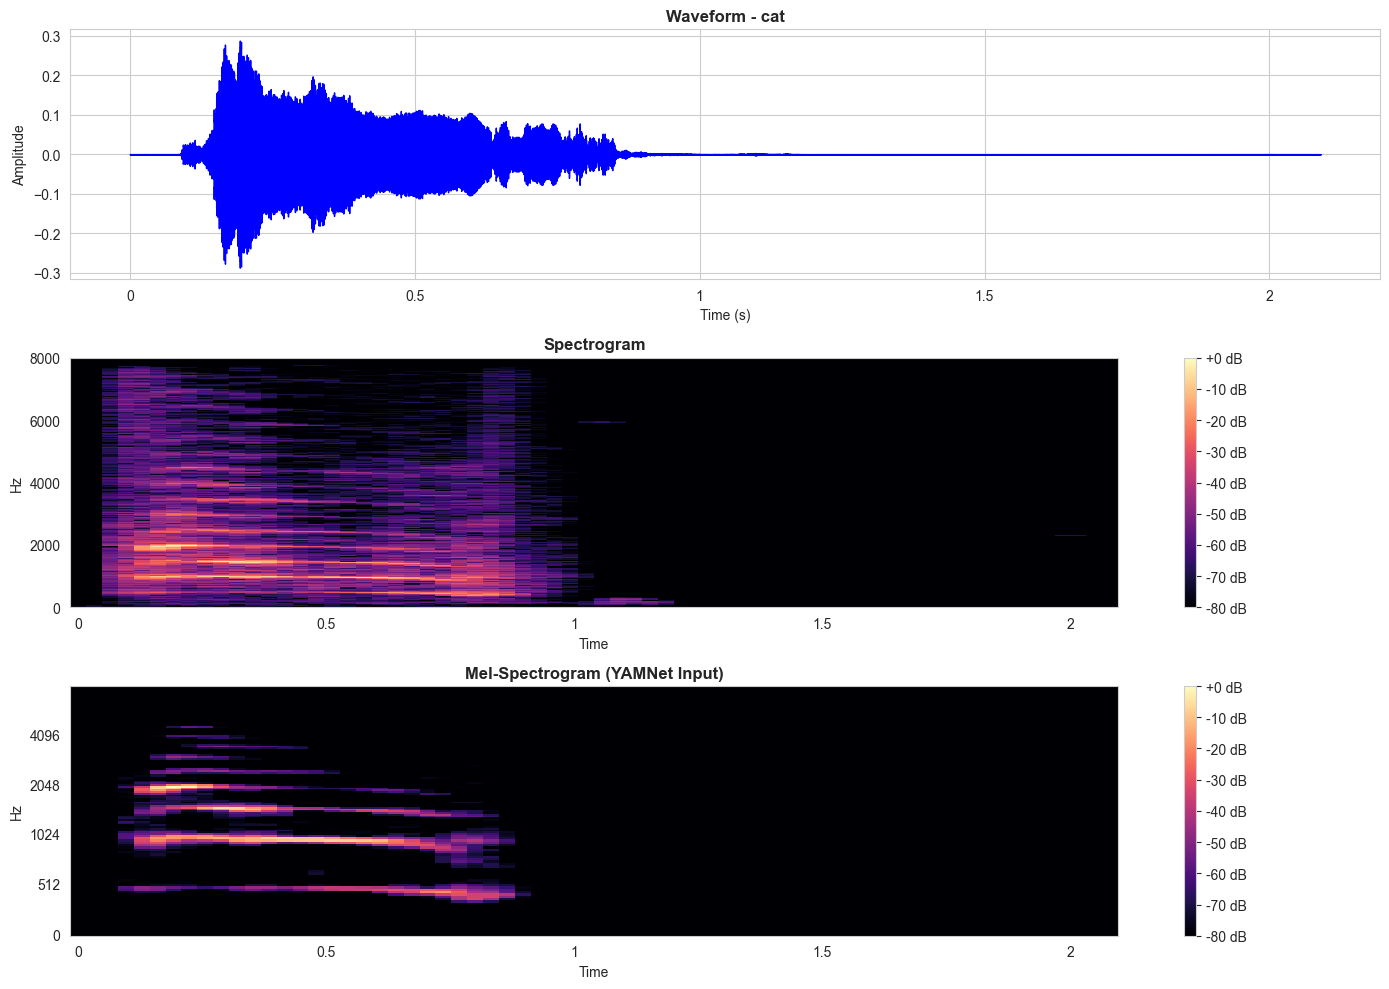

Playing audio from class: cat



Analyzing: dog - Canine_Alert.mp3


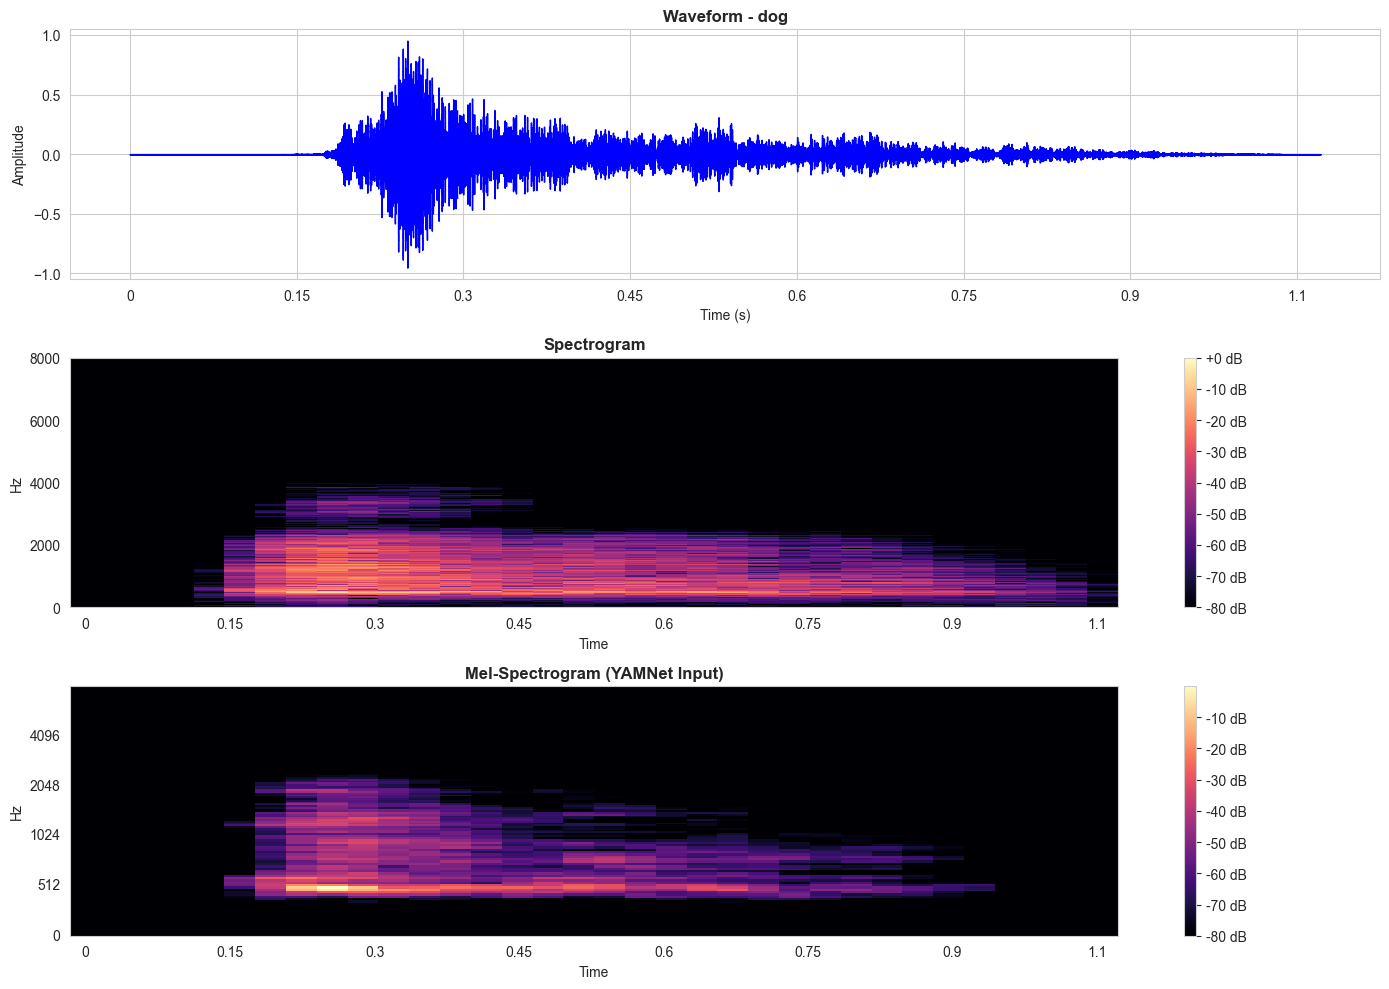

Playing audio from class: dog



Analyzing: police_siren - Cop_Sound.mp3


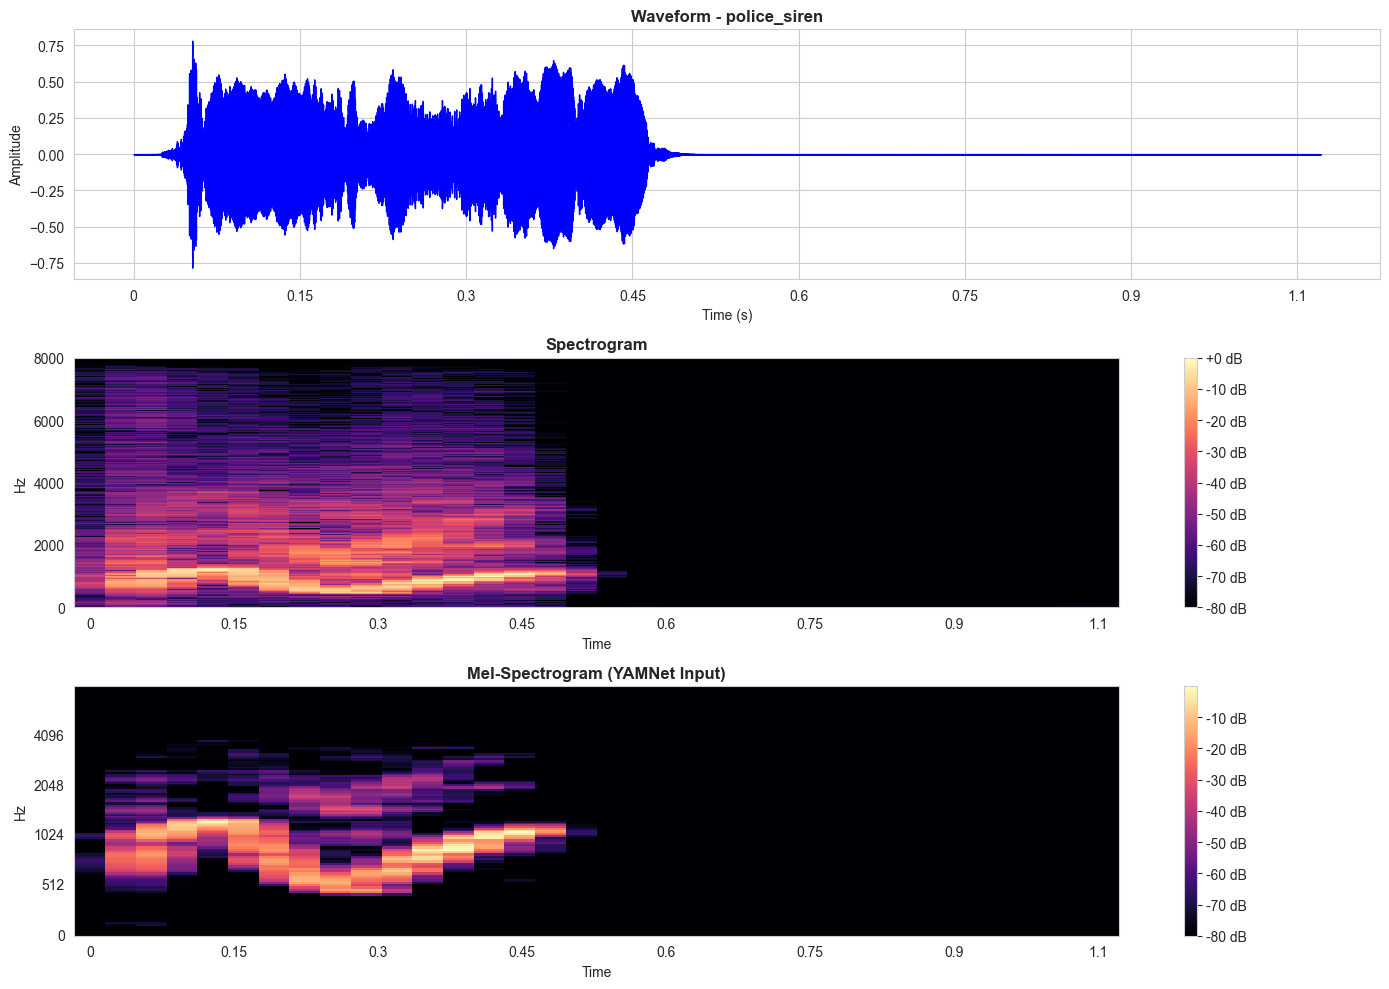

Playing audio from class: police_siren


In [21]:
def plot_audio_sample(file_path, class_name):
    """Plot waveform and spectrogram for an audio sample"""
    # Load audio
    y, sr = librosa.load(file_path, sr=16000)  # YAMNet uses 16kHz
    
    fig, axes = plt.subplots(3, 1, figsize=(14, 10))
    
    # Waveform
    librosa.display.waveshow(y, sr=sr, ax=axes[0], color="b")
    axes[0].set_title(f'Waveform - {class_name}', fontsize=12, fontweight='bold')
    axes[0].set_xlabel('Time (s)')
    axes[0].set_ylabel('Amplitude')
    
    # Spectrogram
    D = librosa.amplitude_to_db(np.abs(librosa.stft(y)), ref=np.max)
    img = librosa.display.specshow(D, sr=sr, x_axis='time', y_axis='hz', ax=axes[1])
    axes[1].set_title('Spectrogram', fontsize=12, fontweight='bold')
    fig.colorbar(img, ax=axes[1], format='%+2.0f dB')
    
    # Mel-spectrogram (what YAMNet uses)
    mel_spec = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128)
    mel_spec_db = librosa.amplitude_to_db(mel_spec, ref=np.max)
    img2 = librosa.display.specshow(mel_spec_db, sr=sr, x_axis='time', y_axis='mel', ax=axes[2])
    axes[2].set_title('Mel-Spectrogram (YAMNet Input)', fontsize=12, fontweight='bold')
    fig.colorbar(img2, ax=axes[2], format='%+2.0f dB')
    
    plt.tight_layout()
    plt.show()
    
    # Play audio
    print(f"Playing audio from class: {class_name}")
    display(Audio(file_path))

# Visualize one sample from each class
print("\n" + "="*60)
print("AUDIO SAMPLES VISUALIZATION")
print("="*60)

for class_name in df['class'].unique():
    sample = df[df['class'] == class_name].iloc[0]
    print(f"\nAnalyzing: {class_name} - {sample['filename']}")
    plot_audio_sample(sample['path'], class_name)

In [22]:
def extract_audio_features(file_path):
    """Extract basic audio features"""
    y, sr = librosa.load(file_path, sr=16000)
    
    features = {
        'duration': len(y) / sr,
        'rms_energy': np.mean(librosa.feature.rms(y=y)),
        'zero_crossing_rate': np.mean(librosa.feature.zero_crossing_rate(y)),
        'spectral_centroid': np.mean(librosa.feature.spectral_centroid(y=y, sr=sr)),
        'spectral_rolloff': np.mean(librosa.feature.spectral_rolloff(y=y, sr=sr))
    }
    return features

print("\n" + "="*60)
print("EXTRACTING AUDIO FEATURES...")
print("="*60)
# Extract features for a subset
feature_list = []
for idx, row in df.head(20).iterrows():  # Sample first 20 for speed
    features = extract_audio_features(row['path'])
    features['class'] = row['class']
    feature_list.append(features)

feature_df = pd.DataFrame(feature_list)


EXTRACTING AUDIO FEATURES...


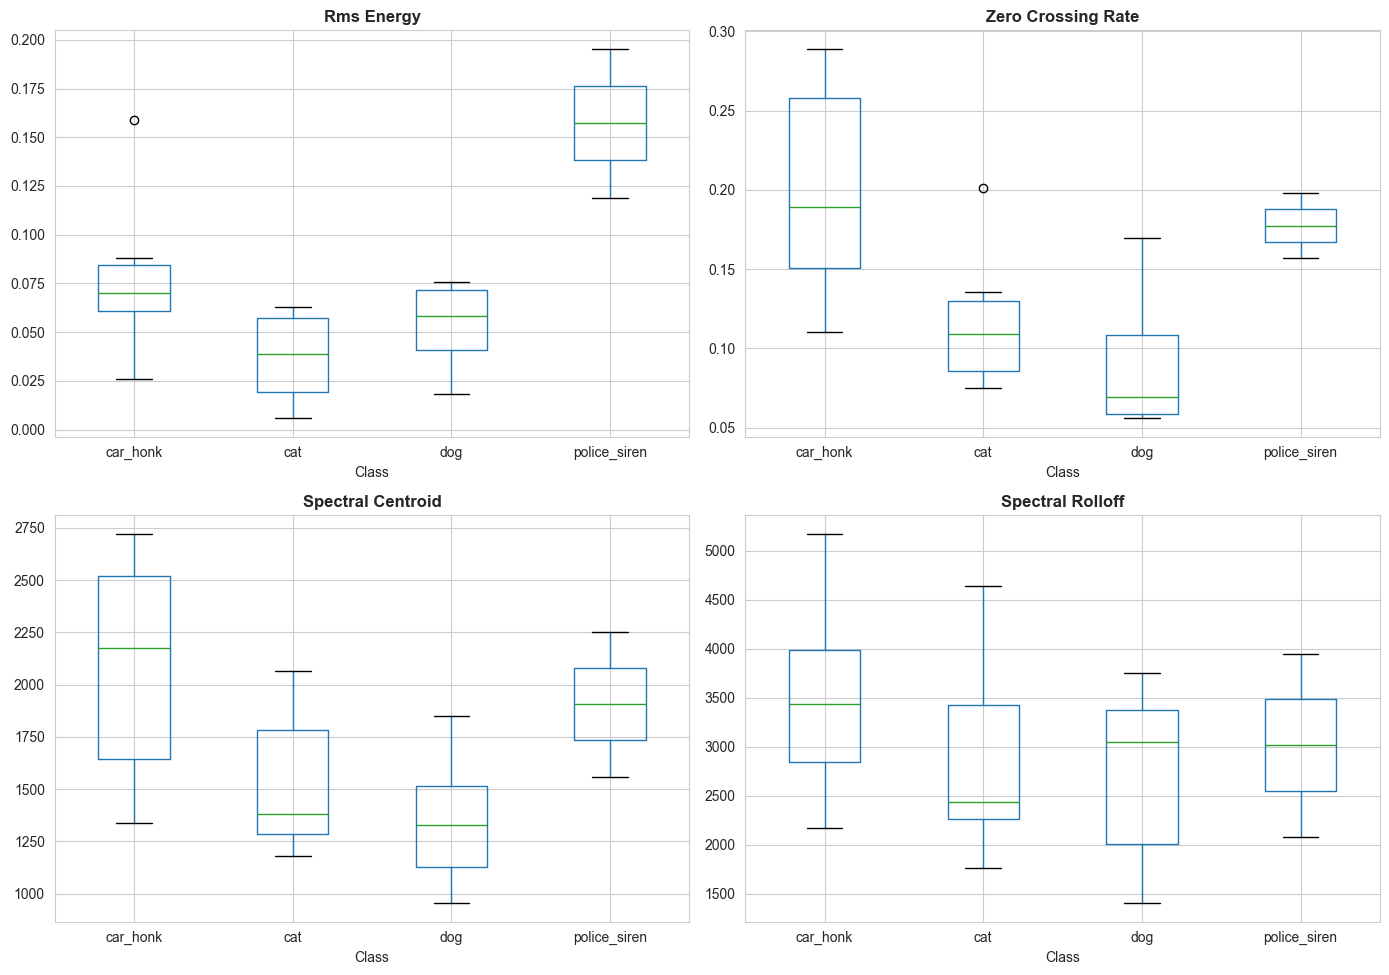

In [23]:
# Visualize features
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

features_to_plot = ['rms_energy', 'zero_crossing_rate', 'spectral_centroid', 'spectral_rolloff']
for idx, feature in enumerate(features_to_plot):
    ax = axes[idx // 2, idx % 2]
    feature_df.boxplot(column=feature, by='class', ax=ax)
    ax.set_title(f'{feature.replace("_", " ").title()}', fontsize=12, fontweight='bold')
    ax.set_xlabel('Class')
    plt.suptitle('')

plt.tight_layout()
plt.show()